# HW4
# 2. Approximated Sampling in the Ising model via MCMC


Yarden Greenpeter - 318517653

Ilay Yoeli - 318260965

Yael Zorea - 209308675


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

## 2.1 Estimation: Comparisons with the Nearly-exact Values

In [6]:
def gibbs_sampler(temp, lattice, num_sweeps):
    # Pad the lattice with zeros to create a 10x10 grid
    padded_lattice = np.pad(lattice, pad_width=1, mode='constant', constant_values=0)
    for _ in range(num_sweeps):
        for i in range(1, lattice.shape[0]+1):
            for j in range(1, lattice.shape[1]+1):
                neighbors_sum = (padded_lattice[i-1, j] + padded_lattice[i+1, j] +
                                 padded_lattice[i, j-1] + padded_lattice[i, j+1])
                p_plus = np.exp(neighbors_sum / temp)
                p_minus = np.exp(-neighbors_sum / temp)
                p_pos = p_plus / (p_plus + p_minus) # Normalization
                padded_lattice[i, j] = 1 if np.random.random() < p_pos else -1
    return padded_lattice[1:-1, 1:-1] # Return the interior

In [7]:
def independent_samples(temp, num_samples=10000, num_sweeps=25):
    e_12_sum = 0
    e_18_sum = 0

    # Initialize an 8x8 lattice with random values
    lattice = np.random.randint(low=0,high=2,size=(8,8))*2-1

    for n in tqdm(range(1, num_samples + 1)):
        # Generate a single sample
        sample = gibbs_sampler(temp, lattice, num_sweeps)

        # Compute the current values
        current_e_12 = sample[0, 0] * sample[1, 1]
        current_e_18 = sample[0, 0] * sample[7, 7]

        # Update the running averages: μ[n] = μ[n-1] + (z_n - μ[n-1]) / n
        e_12_sum += (current_e_12 - e_12_sum) / n
        e_18_sum += (current_e_18 - e_18_sum) / n

    return e_12_sum, e_18_sum


def ergodicity(temp, num_sweeps=25000, burn_in=100):
    # Initialize an 8x8 lattice with random values
    lattice = np.random.randint(low=0,high=2,size=(8,8))*2-1
    e_12_sum, e_18_sum = 0, 0
    for i in tqdm(range(num_sweeps)):
        lattice = gibbs_sampler(temp, lattice, 1)
        if i >= burn_in:
            e_12_sum += lattice[0, 0] * lattice[1, 1]
            e_18_sum += lattice[0, 0] * lattice[7, 7]
    e_12 = e_12_sum / (num_sweeps - burn_in)
    e_18 = e_18_sum / (num_sweeps - burn_in)
    return e_12, e_18

In [8]:
temperatures = [1, 1.5, 2]
exact_results = {
    1: (0.95, 0.9),
    1.5: (0.7610, 0.5532),  # Our results
    2: (0.5022, 0.1268)     # Our results
}

for temp in temperatures:
    print(f"Temperature: {temp}")
    m1_e12, m1_e18 = independent_samples(temp)
    m2_e12, m2_e18 = ergodicity(temp)
    exact_e12, exact_e18 = exact_results[temp]

    print(f"Method 1: E(X(1,1)X(2,2)) = {m1_e12:.4f}, E(X(1,1)X(8,8)) = {m1_e18:.4f}")
    print(f"Method 2: E(X(1,1)X(2,2)) = {m2_e12:.4f}, E(X(1,1)X(8,8)) = {m2_e18:.4f}")
    print(f"Exact:    E(X(1,1)X(2,2)) = {exact_e12:.4f}, E(X(1,1)X(8,8)) = {exact_e18:.4f}")
    print()

Temperature: 1


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

Method 1: E(X(1,1)X(2,2)) = 0.9208, E(X(1,1)X(8,8)) = 0.7094
Method 2: E(X(1,1)X(2,2)) = 0.9526, E(X(1,1)X(8,8)) = 0.9053
Exact:    E(X(1,1)X(2,2)) = 0.9500, E(X(1,1)X(8,8)) = 0.9000

Temperature: 1.5


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

Method 1: E(X(1,1)X(2,2)) = 0.7490, E(X(1,1)X(8,8)) = 0.4012
Method 2: E(X(1,1)X(2,2)) = 0.7579, E(X(1,1)X(8,8)) = 0.5422
Exact:    E(X(1,1)X(2,2)) = 0.7610, E(X(1,1)X(8,8)) = 0.5532

Temperature: 2


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

Method 1: E(X(1,1)X(2,2)) = 0.5214, E(X(1,1)X(8,8)) = 0.0960
Method 2: E(X(1,1)X(2,2)) = 0.5106, E(X(1,1)X(8,8)) = 0.1064
Exact:    E(X(1,1)X(2,2)) = 0.5022, E(X(1,1)X(8,8)) = 0.1268



### Problem 3

**Method 1 (Independent Samples) Results:**

At Temperature 1 (low temperature):
We observed a wide range of values for $E(X(1,1)X(8,8))$ : 0.0868, 0.8350, and 0.6660 (We run the section a few times). This substantial variation suggests that Method 1  may not be allowing the system to consistently capture long-range correlations at low temperatures. This could be due to:
* Insufficient sweeps: 25 sweeps per independent sample may not be enough for the system to converge to the exact results from section-1, particularly for long-range correlations at low temperatures.
* Lack of burn-in period: Method 1 doesn't explicitly include a burn-in period, which could lead to including random configurations on average.

For Temperature 1.5, we observed $E(X(1,1)X(8,8))$ values of 0.4458, 0.3170, and 0.4116.

For Temperature 2, we got 0.1022, 0.0920, and 0.0998.

So, at higher temperatures we colnlude that the range of values narrows significantly as temperature increases. This improved consistency can be attributed to:
* Weaker long-range correlations: Higher temperatures reduce the size of correlated domains, making long-range correlations less significant and easier to sample accurately.
* Improved mixing: Higher temperatures allow for easier transitions between states, enhancing the exploration of the state space even with fewer sweeps.
* Reduced sensitivity to initial conditions: At higher temperatures, the system's behavior becomes less dependent on the starting configuration, leading to more consistent results across different runs.

The results for $E(X(1,1)X(2,2))$ are much more consistent across different runs. The estimates are generally close to the exact values, with slight deviations.
Both methods perform significantly better in estimating $E(X(1,1)X(2,2))$, a short-range correlation, compared to $E(X(1,1)X(8,8))$, a long-range correlation. This is because:
* Short-range correlations equilibrate faster in MCMC simulations.
* They are less affected by finite-size effects in the 8x8 lattice.
* They require less extensive sampling to achieve accurate estimates.

---

**Method 2 (Ergodicity) Results:**

On the other hand, Method 2 generated far more accurate results, especially at lower tempratures. This is because it uses a single, far longer markov chain than Method 1, and includes a burn-in period to discard initial non-equilibriated configuration.

## 2.2 Binary Image Restoration

Temperature: 1


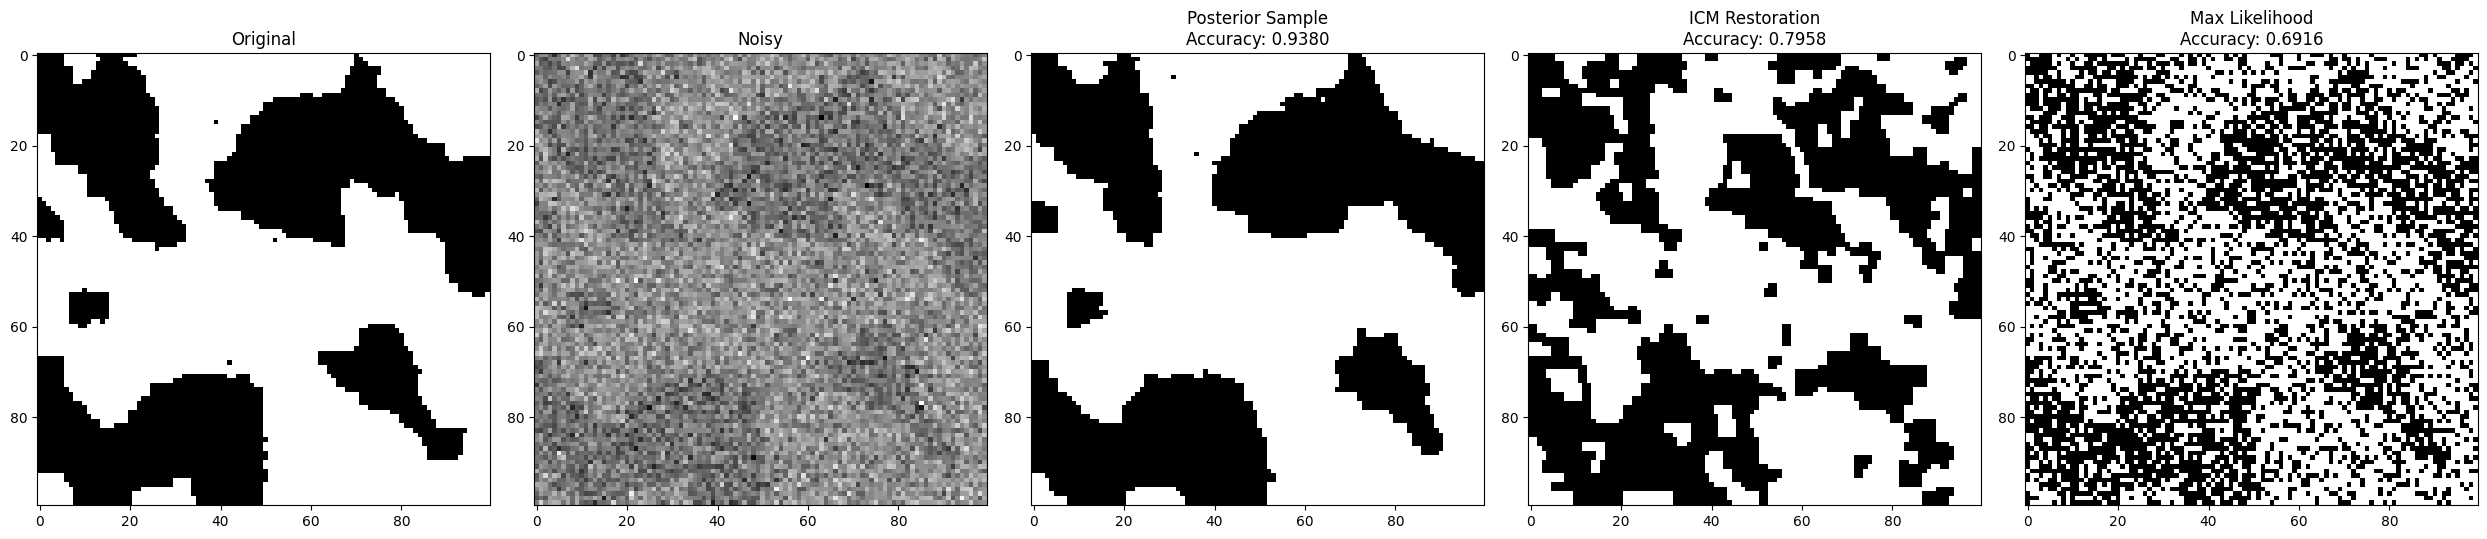


Temperature: 1.5


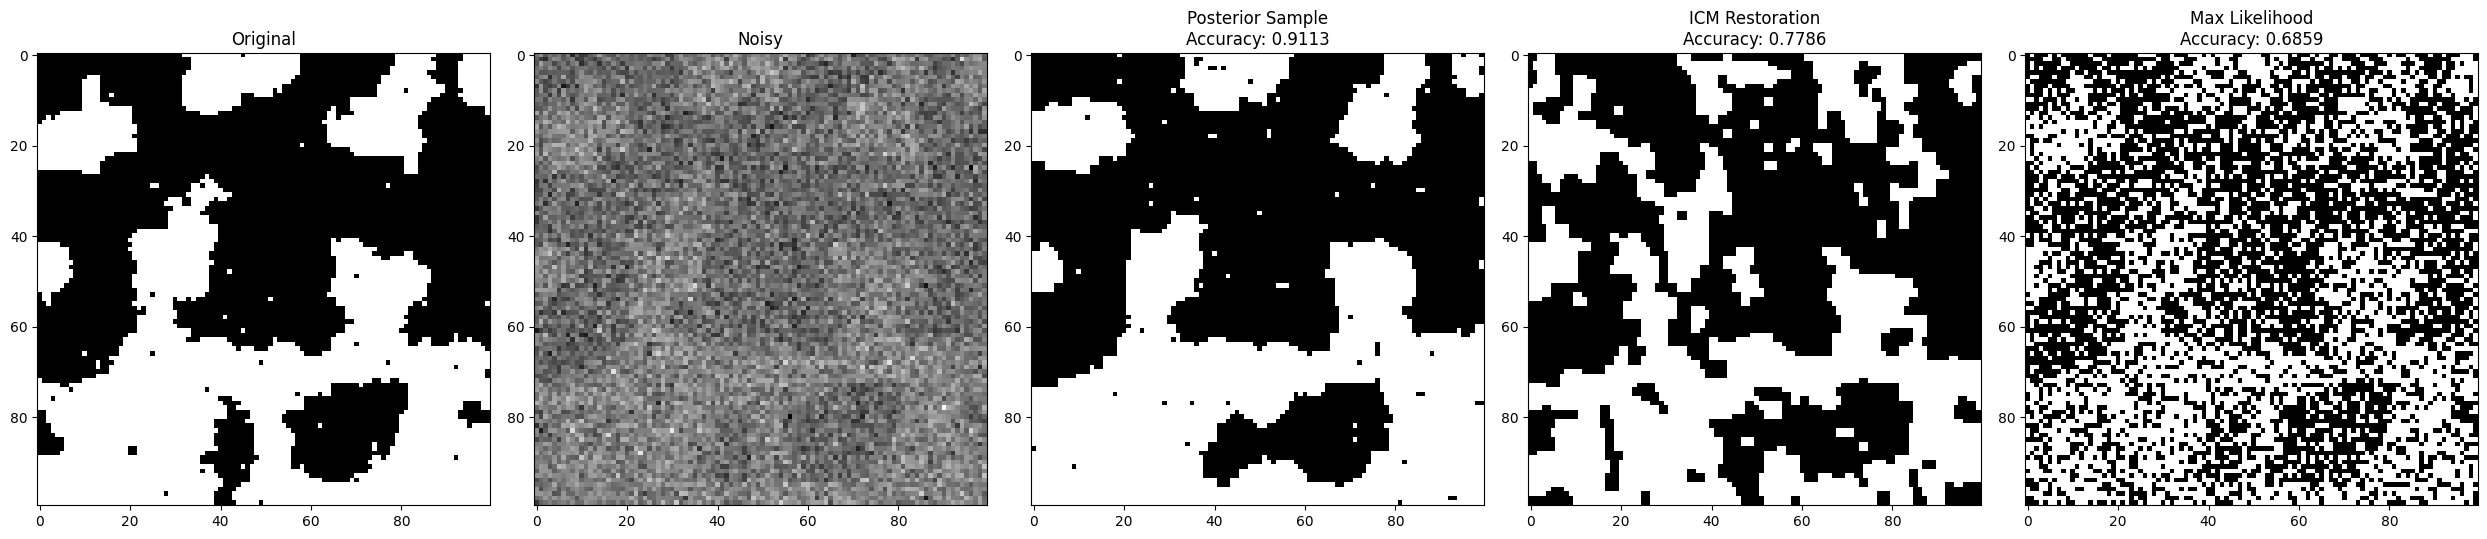


Temperature: 2


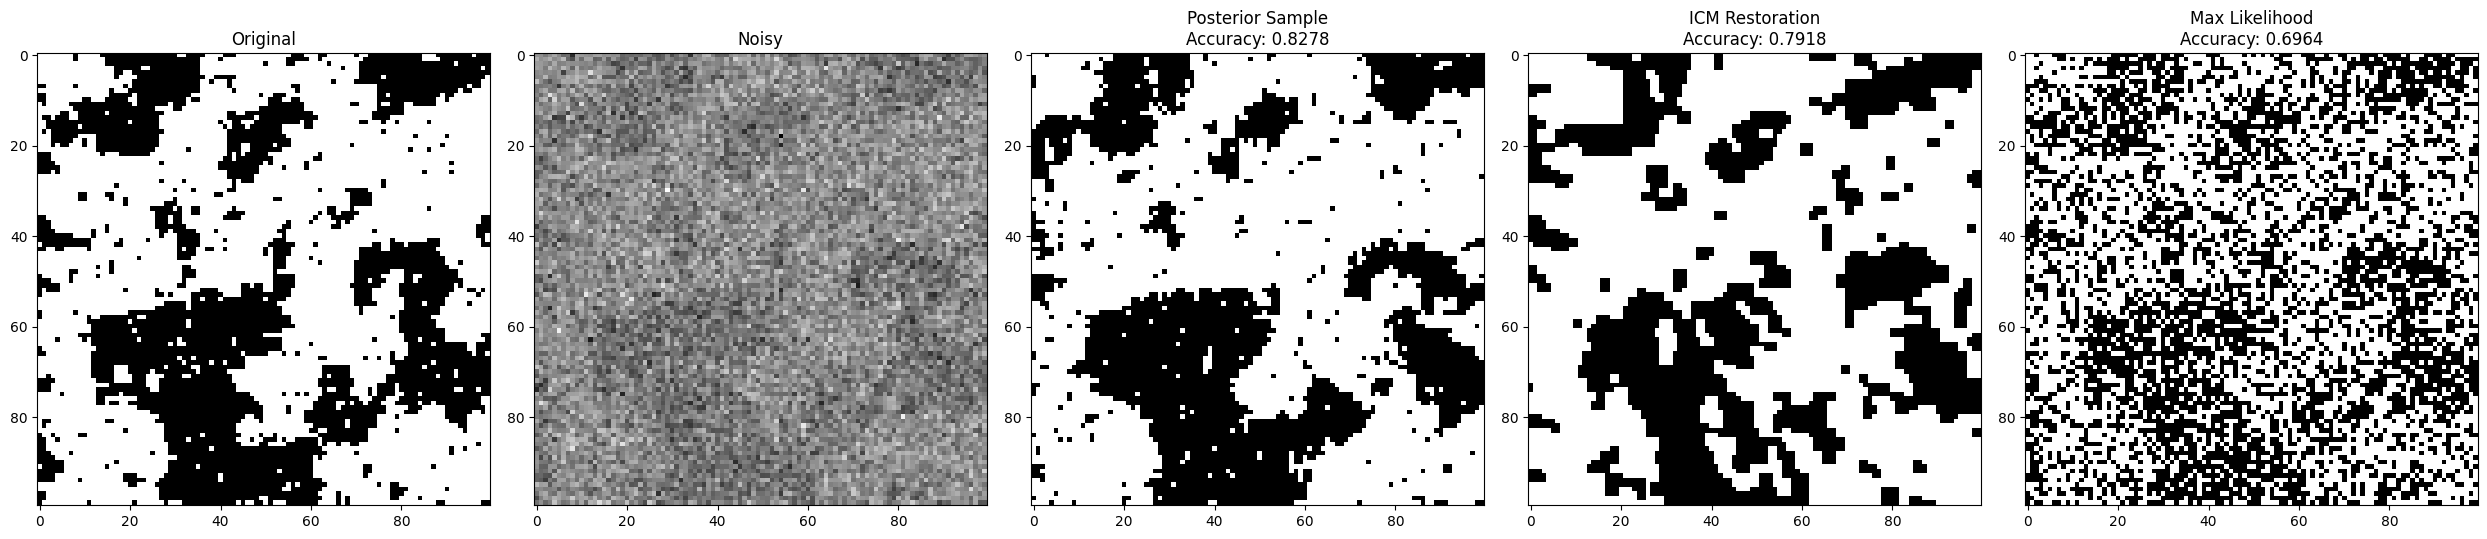

In [9]:
def posterior_gibbs_sampler(temp, y, sigma, lattice, num_sweeps):
    padded_lattice = np.pad(lattice, pad_width=1, mode='constant', constant_values=0)
    for _ in range(num_sweeps):
        for i in range(1, lattice.shape[0]+1):
            for j in range(1, lattice.shape[1]+1):
                neighbors_sum = (padded_lattice[i-1, j] + padded_lattice[i+1, j] +
                                 padded_lattice[i, j-1] + padded_lattice[i, j+1])
                p_plus = np.exp((neighbors_sum + y[i-1, j-1] / sigma**2) / temp)
                p_minus = np.exp((-neighbors_sum - y[i-1, j-1] / sigma**2) / temp)
                p_pos = p_plus / (p_plus + p_minus)
                padded_lattice[i, j] = 1 if np.random.random() < p_pos else -1
    return padded_lattice[1:-1, 1:-1]

def icm_restoration(temp, y, sigma, lattice, num_sweeps):
    padded_lattice = np.pad(lattice, pad_width=1, mode='constant', constant_values=0)
    for _ in range(num_sweeps):
        for i in range(1, lattice.shape[0]+1):
            for j in range(1, lattice.shape[1]+1):
                neighbors_sum = (padded_lattice[i-1, j] + padded_lattice[i+1, j] +
                                 padded_lattice[i, j-1] + padded_lattice[i, j+1])
                p_plus = np.exp((neighbors_sum + y[i-1, j-1] / sigma**2) / temp)
                p_minus = np.exp((-neighbors_sum - y[i-1, j-1] / sigma**2) / temp)
                padded_lattice[i, j] = 1 if p_plus > p_minus else -1
    return padded_lattice[1:-1, 1:-1]

def max_likelihood_estimate(y):
    mle = np.sign(y)
    zero_indices = np.where(y == 0)
    mle[zero_indices] = np.random.choice([-1, 1], size=len(zero_indices[0]))
    return mle

def calculate_accuracy(original, restored):
    return np.mean(original == restored)


# Main execution
temperatures = [1, 1.5, 2]
sigma = 2
lattice_size = 100
num_sweeps = 50

for temp in temperatures:
    print(f"Temperature: {temp}")

    # 1. Generate sample from Ising model
    x = np.random.randint(low=0,high=2,size=(lattice_size,lattice_size))*2-1
    x = gibbs_sampler(temp, x, num_sweeps)

    # 2. Add Gaussian noise
    eta = sigma * np.random.standard_normal(size=x.shape)
    y = x + eta

    # 3. Generate sample from posterior
    x_posterior = np.random.randint(low=0,high=2, size=x.shape)*2-1
    x_posterior = posterior_gibbs_sampler(temp, y, sigma, x_posterior, num_sweeps)

    # 4. ICM restoration
    x_icm = np.random.choice([-1, 1], size=x.shape)
    x_icm = icm_restoration(temp, y, sigma, x_icm, num_sweeps)

    # 5. Maximum likelihood estimate
    x_mle = max_likelihood_estimate(y)

    # Calculate accuracies
    acc_posterior = calculate_accuracy(x, x_posterior)
    acc_icm = calculate_accuracy(x, x_icm)
    acc_mle = calculate_accuracy(x, x_mle)

    # 6. Display all images and accuracies
    fig, axes = plt.subplots(1, 5, figsize=(25, 5))
    axes[0].imshow(x, cmap='gray', vmin=-1, vmax=1)
    axes[0].set_title('Original')
    axes[1].imshow(y, cmap='gray')
    axes[1].set_title('Noisy')
    axes[2].imshow(x_posterior, cmap='gray', vmin=-1, vmax=1)
    axes[2].set_title(f'Posterior Sample\nAccuracy: {acc_posterior:.4f}')
    axes[3].imshow(x_icm, cmap='gray', vmin=-1, vmax=1)
    axes[3].set_title(f'ICM Restoration\nAccuracy: {acc_icm:.4f}')
    axes[4].imshow(x_mle, cmap='gray', vmin=-1, vmax=1)
    axes[4].set_title(f'Max Likelihood\nAccuracy: {acc_mle:.4f}')

    plt.tight_layout()
    plt.show()

    print()